In [1]:
using BenchmarkTools
using StellarChem
using StellarConstants
using StellarEOS

In [2]:
StellarChem.get_isotope_list()

Dict{Symbol, Isotope} with 3352 entries:
  :Ne26  => Isotope(10, 26, "Ne", 26.0005)
  :C22   => Isotope(6, 22, "C", 22.0575)
  :Pr143 => Isotope(59, 143, "Pr", 142.911)
  :Re163 => Isotope(75, 163, "Re", 162.972)
  :Cu52  => Isotope(29, 52, "Cu", 51.9967)
  :Co50  => Isotope(27, 50, "Co", 49.9809)
  :Sr74  => Isotope(38, 74, "Sr", 73.9562)
  :Pt188 => Isotope(78, 188, "Pt", 187.959)
  :No258 => Isotope(102, 258, "No", 258.098)
  :Pb210 => Isotope(82, 210, "Pb", 209.984)
  :Dy148 => Isotope(66, 148, "Dy", 147.927)
  :Hg200 => Isotope(80, 200, "Hg", 199.968)
  :Ir182 => Isotope(77, 182, "Ir", 181.958)
  :Md246 => Isotope(101, 246, "Md", 246.082)
  :Lr251 => Isotope(103, 251, "Lr", 251.094)
  :Cu75  => Isotope(29, 75, "Cu", 74.9415)
  :Ce144 => Isotope(58, 144, "Ce", 143.914)
  :Xe125 => Isotope(54, 125, "Xe", 124.906)
  :Ni66  => Isotope(28, 66, "Ni", 65.9291)
  :Cs114 => Isotope(55, 114, "Cs", 113.941)
  :As60  => Isotope(33, 60, "As", 59.9939)
  :Ne34  => Isotope(10, 34, "Ne", 34.0567)

In [69]:
function equationHSE(sm, k, vm1::Vector{<:TT}, v00::Vector{<:TT}, vp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT})::TT where{TT<:Real}
    ρ = 1 # in cm/g
    R = (3*sm.mstar/(4π*ρ))^(1/3)
    
    if k==sm.nz
        lnP₀ = v00[sm.vari[:lnP]]
        return lnP₀ + 10.0 #force very low surface density to resemble zero pressure condition
    end
    if k==1
        lnP₀ = v00[sm.vari[:lnP]]
        lnP₊ = vp1[sm.vari[:lnP]]
        return lnP₀ - lnP₊#make it simple, just force first to cells to have constant pressure
    end
    lnP₋ = vm1[sm.vari[:lnP]]
    lnP₊ = vp1[sm.vari[:lnP]]
    P₀ = exp(v00[sm.vari[:lnP]])
    r₀ = exp(v00[sm.vari[:lnr]])
    dm = (sm.m[k+1]-sm.m[k-1])
    
    return (P₀*(lnP₊ - lnP₋)/dm + CGRAV*sm.m[k]/(4π*r₀^4))/(CGRAV*sm.mstar/(4π*R^4))
end

function equationT(sm, k, vm1::Vector{<:TT}, v00::Vector{<:TT}, vp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT})::TT where{TT<:Real}
    #if k==1
    #    lnT₀ = v00[sm.vari[:lnT]]
    #    lnT₊ = vp1[sm.vari[:lnT]]
    #    return lnT₀ - lnT₊#make it simple, just force first to cells to have constant temperature
    #end
    if k==sm.nz
        lnT₀ = v00[sm.vari[:lnT]]
        return lnT₀ + 10.0 #force very low surface temperature
    end
    ρ = 1 # in cm/g
    ρ00 = eos00[1]
    return log(ρ)-log(ρ00) # T should be such that the EOS returns the density we want
end

function equationContinuity(sm, k, vm1::Vector{<:TT}, v00::Vector{<:TT}, vp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT})::TT where{TT<:Real}
    ρ = 1 # in cm/g
    R = (3*sm.mstar/(4π*ρ))^(1/3)
    
    if k==1
        lnr₀ = v00[sm.vari[:lnr]]
        return lnr₀ + 10.0 #force very low central radiusw
    end
    r₋ = exp(vm1[sm.vari[:lnr]])
    r₀ = exp(v00[sm.vari[:lnr]])
    dm = (sm.m[k]-sm.m[k-1])

    #expected_r₀ = r₋ + dm/(4π*r₋^2*ρ)
    expected_dr³_dm = 3/(4π*ρ)
    actual_dr³_dm = (r₀^3-r₋^3)/dm
    
    #return log(r₀) - log(expected_r₀)
    return (expected_dr³_dm - actual_dr³_dm)*ρ
end

function equationComposition(sm, k, vm1::Vector{<:TT}, v00::Vector{<:TT}, vp1::Vector{<:TT},
                            eosm1::Vector{<:TT}, eos00::Vector{<:TT}, eosp1::Vector{<:TT})::TT where{TT<:Real}
    return v00[sm.vari[:H1]] - 1.0
end

equationComposition (generic function with 1 method)

In [70]:
using BlockBandedMatrices
using ForwardDiff
using Base.Threads

mutable struct StellarModel
    # properties that define the model
    ind_vars::Vector{<:Real}
    varnames::Vector{Symbol}
    eqs::Vector{<:Real}
    nvars::Int # this is the sum of hydro vars and species
    nspecies::Int # Just the number of species in the network
    structure_equations::Vector{Function} # Be careful, this probably kills type inference
    vari::Dict{Symbol,Int} #links variable names to ind_vars vector

    # grid properties
    nz::Int # number of zones in the model
    m::Vector{<:Real} # mass coordinate of each cell
    mstar::Real # total model mass
    
    # Some basic info
    eos::StellarEOS.AbstractEOS
    isotope_data::Dict{Symbol, Isotope}

    # Jacobian matrix
    jac::BlockBandedMatrix
    function StellarModel(varnames::Vector{Symbol}, structure_equations::Vector{Function}, nvars::Int, nspecies::Int, nz, eos)
        ind_vars = ones(nvars*nz)
        eqs = ones(nvars*nz)
        m = ones(nz)

        l,u = 1,1          # block bandwidths
        N = M = nz        # number of row/column blocks
        cols = rows = [nvars for i in 1:N]  # block sizes

        jac = BlockBandedMatrix(Zeros(sum(rows),sum(cols)), rows,cols, (l,u))

        isotope_data = StellarChem.get_isotope_list();

        vari::Dict{Symbol,Int} = Dict()
        for i in eachindex(varnames)
            vari[varnames[i]] = i
        end

        new(ind_vars, varnames, eqs, nvars, nspecies, structure_equations, vari, nz, m, 0.0,eos,isotope_data,jac)
    end
end

function eval_cell_eqs(sm::StellarModel, k::Int64, ind_vars_view::Vector{<:TT}) where{TT<:Real}
    result = Vector{TT}(undef,sm.nvars)
    # initialize as 
    eosm1 = Vector{TT}(undef,7)
    eos00 = Vector{TT}(undef,7)
    eosp1 = Vector{TT}(undef,7)
    vm1 = Vector{TT}(undef,7)
    v00 = Vector{TT}(undef,7)
    vp1 = Vector{TT}(undef,7)
    if k>1 && k<sm.nz
        eosm1 = get_EOS_resultsTP(sm.eos, sm.isotope_data, ind_vars_view[sm.vari[:lnT]],ind_vars_view[sm.vari[:lnP]],
            ind_vars_view[sm.nvars-sm.nspecies+1:sm.nvars],varnames[sm.nvars-sm.nspecies+1:end])
        eos00 = get_EOS_resultsTP(sm.eos, sm.isotope_data, ind_vars_view[sm.nvars+sm.vari[:lnT]],ind_vars_view[sm.nvars+sm.vari[:lnP]],
            ind_vars_view[sm.nvars+sm.nvars-sm.nspecies+1:2*sm.nvars],varnames[sm.nvars-sm.nspecies+1:end])
        eosp1 = get_EOS_resultsTP(sm.eos, sm.isotope_data, ind_vars_view[2*sm.nvars+sm.vari[:lnT]],ind_vars_view[2*sm.nvars+sm.vari[:lnP]],
            ind_vars_view[2*sm.nvars+sm.nvars-sm.nspecies+1:3*sm.nvars],varnames[sm.nvars-sm.nspecies+1:end])

        vm1 = ind_vars_view[1:sm.nvars]
        v00 = ind_vars_view[sm.nvars+1:2*sm.nvars]
        vp1 = ind_vars_view[2*sm.nvars+1:3*sm.nvars]
    elseif k==1
        eos00 = get_EOS_resultsTP(sm.eos, sm.isotope_data, ind_vars_view[sm.vari[:lnT]],ind_vars_view[sm.vari[:lnP]],
            ind_vars_view[sm.nvars-sm.nspecies+1:sm.nvars],varnames[sm.nvars-sm.nspecies+1:end])
        eosp1 = get_EOS_resultsTP(sm.eos, sm.isotope_data, ind_vars_view[sm.nvars+sm.vari[:lnT]],ind_vars_view[sm.nvars+sm.vari[:lnP]],
            ind_vars_view[sm.nvars+sm.nvars-sm.nspecies+1:2*sm.nvars],varnames[sm.nvars-sm.nspecies+1:end])
        v00 = ind_vars_view[1:sm.nvars]
        vp1 = ind_vars_view[sm.nvars+1:2*sm.nvars]
    elseif k==sm.nz
        eosm1 = get_EOS_resultsTP(sm.eos, sm.isotope_data, ind_vars_view[sm.vari[:lnT]],ind_vars_view[sm.vari[:lnP]],
            ind_vars_view[sm.nvars-sm.nspecies+1:sm.nvars],varnames[sm.nvars-sm.nspecies+1:end])
        eos00 = get_EOS_resultsTP(sm.eos, sm.isotope_data, ind_vars_view[sm.nvars+sm.vari[:lnT]],ind_vars_view[sm.nvars+sm.vari[:lnP]],
            ind_vars_view[sm.nvars+sm.nvars-sm.nspecies+1:2*sm.nvars],varnames[sm.nvars-sm.nspecies+1:end])
        vm1 = ind_vars_view[1:sm.nvars]
        v00 = ind_vars_view[sm.nvars+1:2*sm.nvars]
    end
    for i in 1:sm.nvars
        result[i] = sm.structure_equations[i](sm, k, vm1, v00, vp1, eosm1, eos00, eosp1)
    end
    return result
end

function eval_eqs!(sm::StellarModel)
    for k in 1:sm.nz
        ki = 0
        kf = 0
        if k==1
            ki = sm.nvars*(k-1)+1
            kf = sm.nvars*(k+1)
        elseif k==sm.nz
            ki = sm.nvars*(k-2)+1
            kf = sm.nvars*(k)
        else
            ki = sm.nvars*(k-2)+1
            kf = sm.nvars*(k+1)
        end
        ind_vars_view = sm.ind_vars[ki:kf]
        sm.eqs[sm.nvars*(k-1)+1:sm.nvars*k] = eval_cell_eqs(sm, k, ind_vars_view)
    end
end

function eval_jacobian_row!(sm::StellarModel, k::Int)
    # ranges of ind_vars vector that needs to be considered, needs special cases for k=1 or nz
    # Jacobian has tridiagonal block structure:
    # x x - - - -
    # x x x - - -
    # - x x x - -
    # - - x x x -
    # - - - x x x
    # - - - - x x
    # In the first row, the first block corresponds to the derivatives of the structure equations
    # with respect to the variables at the first cell. The block to the right corresponds to the
    # derivatives with respect to the variables at the second cell.
    # TODO: complete comment
    ki = 0
    kf = 0
    if k==1
        ki = sm.nvars*(k-1)+1
        kf = sm.nvars*(k+1)
    elseif k==sm.nz
        ki = sm.nvars*(k-2)+1
        kf = sm.nvars*(k)
    else
        ki = sm.nvars*(k-2)+1
        kf = sm.nvars*(k+1)
    end
    ind_vars_view = view(sm.ind_vars,ki:kf)
    eval_eqs_wrapper = x->eval_cell_eqs(sm, k, x)
    sm.jac[sm.nvars*(k-1)+1:sm.nvars*k,ki:kf] = ForwardDiff.jacobian(eval_eqs_wrapper, ind_vars_view)
end

function eval_jacobian!(sm::StellarModel)
    Threads.@threads for k in 1:sm.nz
        eval_jacobian_row!(sm, k)
    end
end

eval_jacobian! (generic function with 1 method)

In [71]:
nvars = 4
nspecies = 1
varnames = [:lnP,:lnT,:lnr,:H1]
structure_equations=[equationHSE, equationT, equationContinuity, equationComposition]
nz = 1000
eos = StellarEOS.IdealEOS(true)
sm = StellarModel(varnames, structure_equations, nvars, nspecies, nz, eos);

In [72]:
sm.mstar = MSUN
function r_const_ρ(m,ρ)
    return @. (3m/(4π*ρ))^(1/3)
end
function P_const_ρ(m,ρ,M)
    Pc = 3*CGRAV/(8π)*(4π*ρ/3)^(4/3)*M^(2/3)
    return @. -3*CGRAV/(8π)*(4π*ρ/3)^(4/3)*m^(2/3) + Pc
end
function T_const_ρ(m,ρ,M, XH1, XHe4, isotope_data)
    P = P_const_ρ(m,ρ,M)
    μ = StellarEOS.get_μ_IdealEOS(isotope_data,[XH1,XHe4], [:H1,:He4])
    return @. P*μ/(CGAS*ρ)
end

T_const_ρ (generic function with 1 method)

In [73]:
using CairoMakie

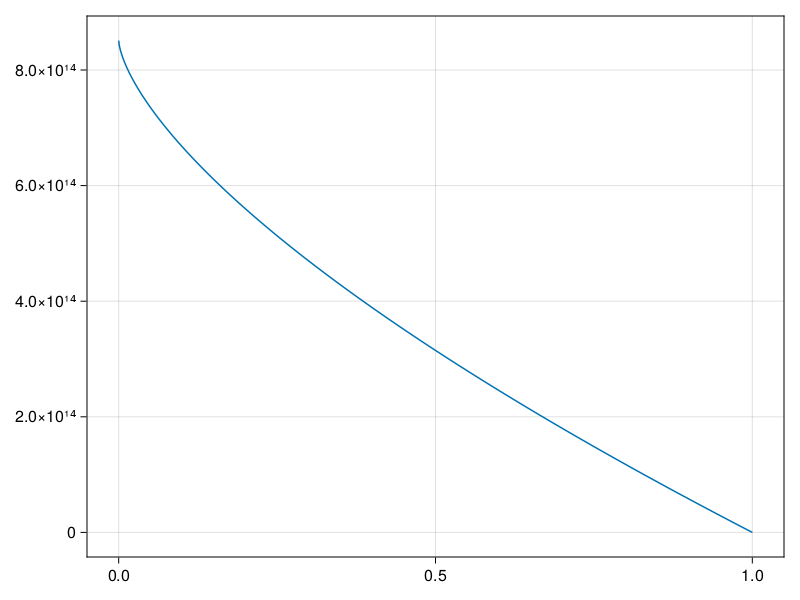

In [74]:
f = Figure()
ax = Axis(f[1,1])
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
#lines!(ax, xvals, T_const_ρ(mass,1,MSUN, 0.7,0.3,StellarChem.get_isotope_list()))
f

In [75]:
isotope_list = StellarChem.get_isotope_list()
for i in 1:sm.nz
    sm.m[i] = MSUN*(i-1)/(sm.nz-1)
    ρ = 1
    XH = 1.0
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnr]] = log(r_const_ρ(sm.m[i],ρ))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnP]] = log(P_const_ρ(sm.m[i],ρ,MSUN))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:lnT]] = log(T_const_ρ(sm.m[i],ρ,MSUN,1.0,0.0,isotope_list))
    sm.ind_vars[(i-1)*sm.nvars+sm.vari[:H1]] = XH
end
#special cases, just copy values at edges
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnr]] = -10
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnP]] = sm.ind_vars[(2-1)*sm.nvars+sm.vari[:lnP]]
sm.ind_vars[(1-1)*sm.nvars+sm.vari[:lnT]] = sm.ind_vars[(2-1)*sm.nvars+sm.vari[:lnT]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnr]] = sm.ind_vars[(sm.nz-2)*sm.nvars+sm.vari[:lnr]]
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnP]] = -10
sm.ind_vars[(sm.nz-1)*sm.nvars+sm.vari[:lnT]] = -10

-10

In [76]:
sm.ind_vars .= sm.ind_vars .+ rand(sm.nvars*sm.nz)./100;

In [77]:
eval_jacobian_row!(sm,sm.nz)

4×8 Matrix{Float64}:
  0.0   0.0    0.0     0.0   1.0   0.0     0.0    0.0
  0.0   0.0    0.0     0.0   0.0   1.0     0.0    0.0
 -0.0  -0.0  734.304  -0.0  -0.0  -0.0  -717.45  -0.0
  0.0   0.0    0.0     0.0   0.0   0.0     0.0    1.0

In [78]:
@benchmark eval_jacobian_row!(sm,2)

BenchmarkTools.Trial: 10000 samples with 7 evaluations.
 Range (min … max):  3.958 μs … 261.554 μs  ┊ GC (min … max):  0.00% … 95.07%
 Time  (median):     4.304 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   5.056 μs ±  12.165 μs  ┊ GC (mean ± σ):  11.79% ±  4.81%

     ▂▆█▄                                                      
  ▂▄▆████▆▄▃▃▃▃▂▂▂▂▂▂▂▂▂▂▁▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂▂ ▃
  3.96 μs         Histogram: frequency by time        7.75 μs <

 Memory estimate: 16.12 KiB, allocs estimate: 69.

In [79]:
@benchmark eval_jacobian!(sm)

BenchmarkTools.Trial: 1786 samples with 1 evaluation.
 Range (min … max):  758.022 μs … 34.255 ms  ┊ GC (min … max):  0.00% … 94.90%
 Time  (median):       1.327 ms              ┊ GC (median):     0.00%
 Time  (mean ± σ):     2.808 ms ±  6.175 ms  ┊ GC (mean ± σ):  47.58% ± 19.73%

  ▅█▆                                                           
  ███▇▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▅▇██▇ █
  758 μs        Histogram: log(frequency) by time      31.7 ms <

 Memory estimate: 15.80 MiB, allocs estimate: 73399.

In [80]:
eval_eqs!(sm)

In [81]:
sm.eqs[sm.nvars*0+1:sm.nvars*110]

440-element Vector{Float64}:
 -0.003055778781202889
  0.00509073014664603
  0.0023815058526981403
  0.005920563734116424
  8.123659645194138
  0.004001793649180211
 -0.004773985659348751
  0.009670838508236024
 -0.782473739670987
 -0.0016039994717034023
  0.0033638650438335693
  0.004629741751910554
 -2.1137987713104676
  ⋮
 -1.8262397102647148
  0.009476262193637768
  0.4508263572828002
  2.9987934941910765e-5
  4.574906303148426
  0.008590894488270256
 -0.221187926823751
  0.006727021033911651
  0.8179190094713203
  0.0005077544365202511
 -0.2317536856335225
  0.0017787014922701072

In [82]:
(sm.jac\sm.eqs)

4000-element Vector{Float64}:
  0.0024333195042558673
  0.0016299841882476632
  0.0023815058526981403
  0.005920563734116424
  0.005489098285472336
 -7.560373250653712e-5
  0.006535058426283903
  0.009670838508236024
  0.01365375582870368
  0.007409595514841921
  0.0009815510401593136
  0.004629741751910554
  0.004638022655345434
  ⋮
  0.5684529315733542
  0.5678751578010564
  0.004442077605074588
  0.008806398490671885
  0.9324591575757333
  0.9369559163728338
  0.008869701603580965
  0.002268697651059526
  0.005837624314251499
  0.0005221860955693103
  0.0009146740990707756
  0.007803356965181418

In [83]:
for i in 1:4
    eval_jacobian!(sm)
    eval_eqs!(sm)
    corr = sm.jac\(-sm.eqs)
    #scale correction
    corr = corr*min(1,0.1/maximum(corr))
    @show maximum(corr)
    sm.ind_vars = sm.ind_vars+corr
end

maximum(corr) = 0.0012190354734534035
maximum(corr) = 0.0005386193572717711
maximum(corr) = 1.4195931129072827e-15
maximum(corr) = 1.876958016896873e-15


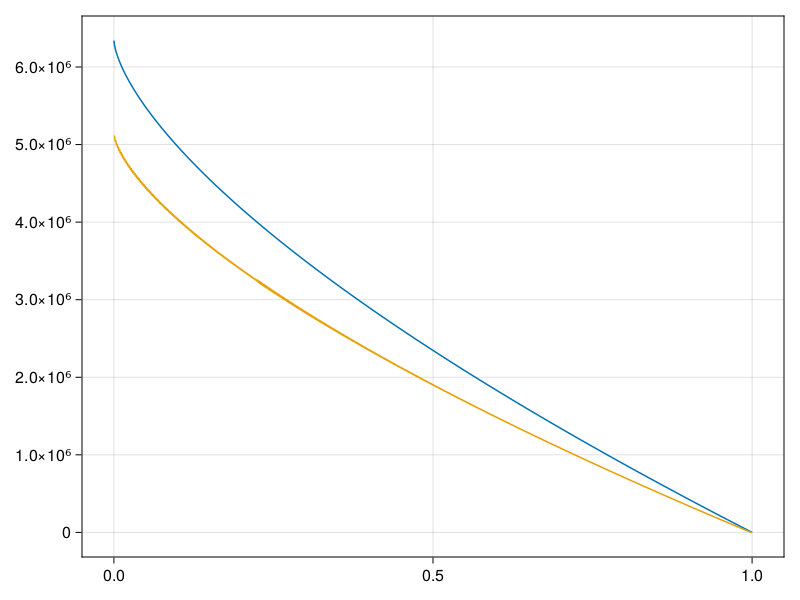

In [84]:
f = Figure()
ax = Axis(f[1,1])
xvals = collect(LinRange(0,1,1000))
mass = xvals .* MSUN
#lines!(ax, xvals, P_const_ρ(mass,1,MSUN))
lines!(ax, xvals, T_const_ρ(mass,1,MSUN, 0.7,0.3,StellarChem.get_isotope_list()))
lines!(ax, sm.m./sm.mstar, exp.([sm.ind_vars[sm.nvars*(k-1)+sm.vari[:lnT]] for k in 1:sm.nz]))
f

In [67]:
sm.ind_vars

4000-element Vector{Float64}:
  34.36958971877807
  15.446110073063991
 -10.0
   1.0
  34.36958971877807
  15.446110073063991
  22.77795795990407
   1.0
  34.356144696876925
  15.43274490312565
  23.00900702009072
   1.0
  34.35877395282239
   ⋮
  26.588755484841275
   7.667309561164476
  25.079541549891353
   1.0
  24.248416116775005
   5.32697019309835
  25.07987571867456
   1.0
 -10.0
 -10.0
  25.080209552786926
   1.0